In [171]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

#### Hyprerparameters

In [173]:
np.random.seed(1)
torch.manual_seed(1)

NUM_MODEL = 8
NUM_MIN = 50 # for plotting minimal ratio
LR = 5e-3
EPOCH = 7000
# for 2nd training
LR2 = 1e-4
EPOCH2 = 1000
USE_CUDA = torch.cuda.is_available()

#### Generate Data

In [174]:
def sample_func(x):
    return np.sinc(x)

In [175]:
train_x = (2 * np.random.rand(2000)-1) * 3
train_y = sample_func(train_x)
train_x, train_y = Variable(torch.FloatTensor(train_x)), Variable(torch.FloatTensor(train_y))
train_x = train_x.unsqueeze(1)
train_y = train_y.unsqueeze(1)

#### Define Network Structure

In [176]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

#### Set Loss

In [177]:
loss_func = nn.MSELoss()

#### Some Helper Functions

In [191]:
def calculate_grad(model):
    grad_all = 0
    for layer in model.parameters():
        if layer.grad is not None:
            grad = (layer.grad.data.numpy() **2).sum()
            grad_all += grad
    return grad_all

# this function can add grad into computational graph
def calculate_grad2(model, loss):
    grad_norm = 0
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True, retain_graph=True)
    for grad in grad_params:
        grad_norm += grad.pow(2).sum()
    return grad_norm

def minimal_ratio(matrix):
    w, _ = np.linalg.eig(matrix)
    return (w > 0).mean()

# dosent work ...
def calculate_hessian(loss, model):
    var = model.parameters()
    temp = []
    grads = torch.autograd.grad(loss, var, create_graph=True)
    grads = torch.cat([g.view(-1) for g in grads])
    for grad in grads:
        grad2 = torch.autograd.grad(grad, var, create_graph=True)
        temp.append(grad2)
    return np.array(temp)

# return a layer-structured hessian matrix (bad)
def calculate_hessian2(loss, model):
    var = [ i for i in model.parameters()]
    temp = []
    grads = torch.autograd.grad(loss, var, create_graph=True, retain_graph=True)
    for layer in grads:
        for grad in layer:
            for g in grad:
                temp2 = []
#                 g.backward(retain_graph=True) # not necessary
                for v in var:
                    grad2 = torch.autograd.grad(g, v, create_graph=True, retain_graph=True)
                    for grd in grad2:
                        temp2.append(grd)
                temp.append(temp2)
    return np.array(temp)

# return a 2D hessian matrix (good)
def calculate_hessian3(loss, model):
    var = [ i for i in model.parameters()]
    hessian = torch.zeros(1)
    grads = torch.autograd.grad(loss, var, create_graph=True, retain_graph=True)
    for layer in grads:
        for grad in layer:
            for g in grad:
                temp2 = []
                for v in var:
                    grad2 = torch.autograd.grad(g, v, create_graph=True, retain_graph=True)
                    for grd in grad2:
                        # make the 
                        grd.contiguous()
                        grd = grd.data.view(-1)
                        hessian = torch.cat((hessian, grd), 0)
    size = int(np.sqrt(hessian.size()))
    return np.array(hessian[1:].view(size, size))

def get_W(model):
    var = model.parameters()
    W = torch.zeros(1)
    for v in var:
        W = torch.cat((W, v.data.view(-1)), 0)
    return W[1:].numpy()

#### little test

In [179]:
minimal_ratio(np.diag([1,-1,-1]))

0.3333333333333333

In [180]:
get_W(net).shape

(609,)

# 1. Visualize the Optimization Process

In [181]:
# manage models
model_list = [Net() for i in range(NUM_MODEL) ]
optim_list = [optim.Adam(params=m.parameters(), lr=LR) for m in model_list]
Ws = []

In [150]:
for step, (model, optimizer) in enumerate(zip(model_list, optim_list)):
    print("training model #%d" % (step + 1))
    for epoch in range(EPOCH):
        pred = model(train_x)
        optimizer.zero_grad()
        loss = loss_func(pred, train_y)
        loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            print("loss: %.6f" % loss.data[0])
            W = get_W(model)
            Ws.append(W)
Ws = np.array(Ws)

training model #1
loss: 0.4016
loss: 0.0002
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0002
training model #2
loss: 0.2062
loss: 0.0001
loss: 0.0007
loss: 0.0000
loss: 0.0000
loss: 0.0002
loss: 0.0000
training model #3
loss: 0.1639
loss: 0.0010
loss: 0.0001
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
training model #4
loss: 0.2157
loss: 0.0014
loss: 0.0013
loss: 0.0013
loss: 0.0013
loss: 0.0001
loss: 0.0000
training model #5
loss: 0.1424
loss: 0.0027
loss: 0.0026
loss: 0.0043
loss: 0.0013
loss: 0.0013
loss: 0.0015
training model #6
loss: 0.1468
loss: 0.0013
loss: 0.0013
loss: 0.0014
loss: 0.0013
loss: 0.0001
loss: 0.0000
training model #7
loss: 0.3068
loss: 0.0020
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
training model #8
loss: 0.3251
loss: 0.0026
loss: 0.0029
loss: 0.0026
loss: 0.0025
loss: 0.0001
loss: 0.0001


#### Dimension Reduction by PCA

In [162]:
pca = PCA(n_components=2)
pca.fit(Ws)
Ws_2D = pca.transform(Ws)
# make it easy for plotting
Ws_2D = Ws_2D.T

(56, 2)

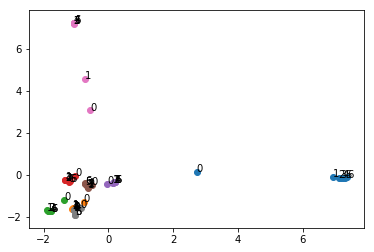

In [167]:
for i in range(8):
    for j in range(7):
        plt.scatter(Ws_2D[i*7 + j][0], Ws_2D[i*7 + j][1], color='C%d' % i)
        plt.text(Ws_2D[i*7 + j][0], Ws_2D[i*7 + j][1], "%d" % j)
plt.show()

# 2. Observe Gradient Norm During Training


In [182]:
def normal_train(verbose=False):
    net = Net()
    optimizer = optim.Adam(params=net.parameters(), lr=LR)
    grad_list = []
    loss_list = []
    for epoch in range(EPOCH):
        pred = net(train_x)
        loss = loss_func(pred, train_y)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        grad_list.append(calculate_grad(net))
        loss_list.append(loss.data[0])

        if verbose and epoch % 1000 == 0:
            print('epoch: %4d | loss: %.6f | grad: %.6f' % (epoch, loss.data[0], calculate_grad(net)))
            plt.figure()
            plt.scatter(train_x, train_y, label="ground_truth")
            plt.scatter(train_x, pred.data, label="model")
            plt.title("model")
            plt.legend()
            plt.show()
    return net, grad_list, loss_list     

epoch:    0 | loss: 0.254829 | grad: 2.398980


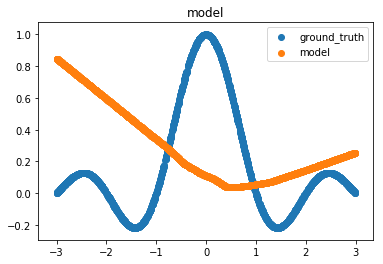

epoch: 1000 | loss: 0.002593 | grad: 0.000001


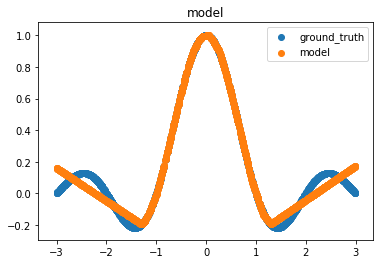

epoch: 2000 | loss: 0.002592 | grad: 0.000000


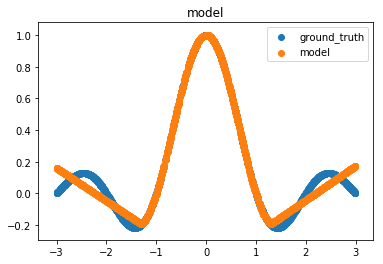

epoch: 3000 | loss: 0.002592 | grad: 0.000001


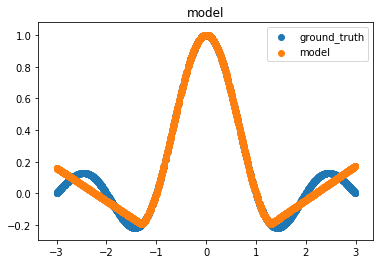

epoch: 4000 | loss: 0.000132 | grad: 0.000003


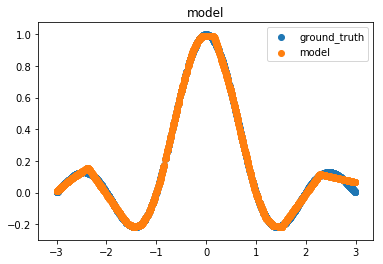

epoch: 5000 | loss: 0.000056 | grad: 0.000000


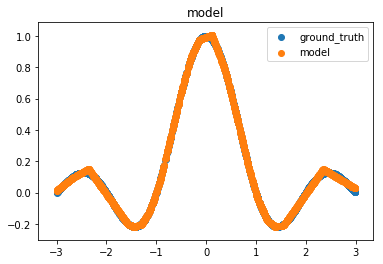

epoch: 6000 | loss: 0.000050 | grad: 0.000000


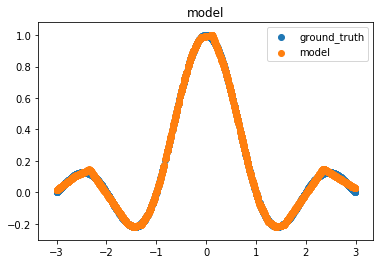

In [183]:
net, grad_list, loss_list = normal_train(verbose=True)

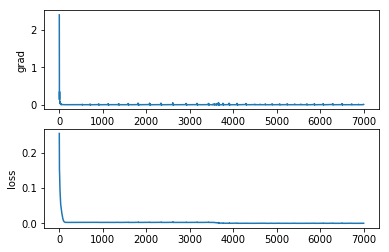

In [186]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(EPOCH), (np.array(grad_list)))
ax[1].plot(np.arange(EPOCH), (np.array(loss_list)))
ax[0].set_ylabel('grad')
ax[1].set_ylabel('loss')
plt.show()

# 3. What Happened When Gradient is Almost Zero

In [192]:
def grad_train(net, verbose=False):
    # minimize grad (change the loss to grad_norm)
    grad_list = []
    loss_list = []
    optimizer = optim.Adam(net.parameters(), lr=LR2)
    for epoch in range(EPOCH2):
        pred = net(train_x)
        loss = loss_func(pred, train_y)
        optimizer.zero_grad()

        # instead of backward by loss, this time backward by grad_norm
        grad_norm = calculate_grad2(net, loss)
        grad_norm.backward(retain_graph=True)

        optimizer.step()

        grad_list.append(calculate_grad(net))
        loss_list.append(loss.data[0])

        if verbose and epoch % 100 == 0:
            print('epoch: %4d | loss: %.6f | grad: %.6f' % (epoch, loss.data[0], calculate_grad(net)))
            plt.figure()
            plt.scatter(train_x, train_y, label="ground_truth")
            plt.scatter(train_x, pred.data, label="model")
            plt.title("model")
            plt.legend()
            plt.show()
    return net, loss, grad_list, loss_list

In [194]:
losses = []
mini = []
for i in range(NUM_MIN):
    print("training... #%2d / %2d" % (i+1, NUM_MIN))
    net, _, _ = normal_train()
    net, loss, grad_list2, loss_list2 = grad_train(net)
    hessian = calculate_hessian3(loss, net)
    min_ratio = minimal_ratio(hessian)
    losses.append(loss.data[0])
    mini.append(min_ratio)

training... # 1 / 50
training... # 2 / 50
training... # 3 / 50
training... # 4 / 50
training... # 5 / 50
training... # 6 / 50
training... # 7 / 50
training... # 8 / 50
training... # 9 / 50
training... #10 / 50
training... #11 / 50
training... #12 / 50
training... #13 / 50
training... #14 / 50
training... #15 / 50
training... #16 / 50
training... #17 / 50
training... #18 / 50
training... #19 / 50
training... #20 / 50
training... #21 / 50
training... #22 / 50
training... #23 / 50
training... #24 / 50
training... #25 / 50
training... #26 / 50
training... #27 / 50
training... #28 / 50
training... #29 / 50
training... #30 / 50
training... #31 / 50
training... #32 / 50
training... #33 / 50
training... #34 / 50
training... #35 / 50
training... #36 / 50
training... #37 / 50
training... #38 / 50
training... #39 / 50
training... #40 / 50
training... #41 / 50
training... #42 / 50
training... #43 / 50
training... #44 / 50
training... #45 / 50
training... #46 / 50
training... #47 / 50
training... #

(-0.001, 0.005)

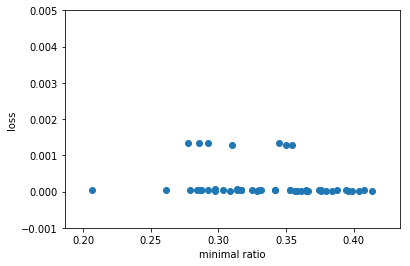

In [198]:
plt.scatter(mini, losses)
plt.xlabel('minimal ratio')
plt.ylabel('loss')
plt.ylim(-0.001, 0.005)

#### (Note) the eigenvalues of hessian is full of zeros

In [199]:
hessian = calculate_hessian3(loss, net)
print(hessian.shape)
min_ratio = minimal_ratio(hessian)
print(min_ratio)

(609, 609)
0.3645320197044335


In [200]:
w, _ = np.linalg.eig(hessian)
print("number of total eigenvalue: ", w.size)
print("number of zero eigenvalue:", (w == 0).sum())
print("zero ratio : %.2f%%" % ((w == 0).sum()/w.size * 100))

number of total eigenvalue:  609
number of zero eigenvalue: 236
zero ratio : 38.75%


In [201]:
print("elements in hessian: ", hessian.size)
print("zero in hessian: ", (hessian == 0).sum())
print("zero ratio: %.2f%%" % ((hessian == 0).sum()/hessian.size * 100))

elements in hessian:  370881
zero in hessian:  279368
zero ratio: 75.33%


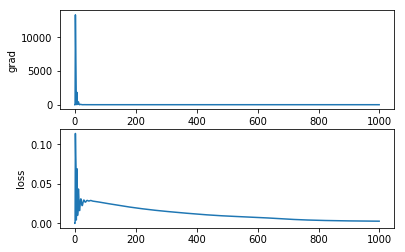

In [202]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(EPOCH2), (np.array(grad_list2)))
ax[1].plot(np.arange(EPOCH2), (np.array(loss_list2)))
ax[0].set_ylabel('grad')
ax[1].set_ylabel('loss')
plt.show()

## (Reference)To Calculate Higher Order Gradient
https://github.com/pytorch/pytorch/releases/tag/v0.2.0
```python
import torch
from torchvision.models import resnet18
from torch.autograd import Variable

model = resnet18().cuda()

# dummy inputs for the example
input = Variable(torch.randn(2,3,224,224).cuda(), requires_grad=True)
target = Variable(torch.zeros(2).long().cuda())

# as usual
output = model(input)
loss = torch.nn.functional.nll_loss(output, target)

grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
# torch.autograd.grad does not accumuate the gradients into the .grad attributes
# It instead returns the gradients as Variable tuples.

# now compute the 2-norm of the grad_params
grad_norm = 0
for grad in grad_params:
    grad_norm += grad.pow(2).sum()
grad_norm = grad_norm.sqrt()

# take the gradients wrt grad_norm. backward() will accumulate
# the gradients into the .grad attributes
grad_norm.backward()

# do an optimization step
optimizer.step()
```

## (Reference) 
https://discuss.pytorch.org/t/calculating-hessian-vector-product/11240/3
```python
v = Variable(torch.Tensor([1, 1]))
x = Variable(torch.Tensor([0.1, 0.1]), requires_grad=True)
f = 3 * x[0] ** 2 + 4 * x[0] * x[1] + x[1] **2
grad_f, = torch.autograd.grad(f, x, create_graph=True)
z = grad_f @ v
```

https://discuss.pytorch.org/t/runtimeerror-input-is-not-contiguous/930/3

:before view(-1), you should make a tensor contiguous (in memory)

In [ ]:
##TEST SECTION##
a = torch.FloatTensor([1])
b = torch.FloatTensor([3])

a, b = Variable(a, requires_grad=True), Variable(b, requires_grad=True)

c = a + 3 * b**2
c = c.sum()

grad_b = torch.autograd.grad(c, b, create_graph=True)
grad2_b = torch.autograd.grad(grad_b, b, create_graph=True)

print(grad2_b)